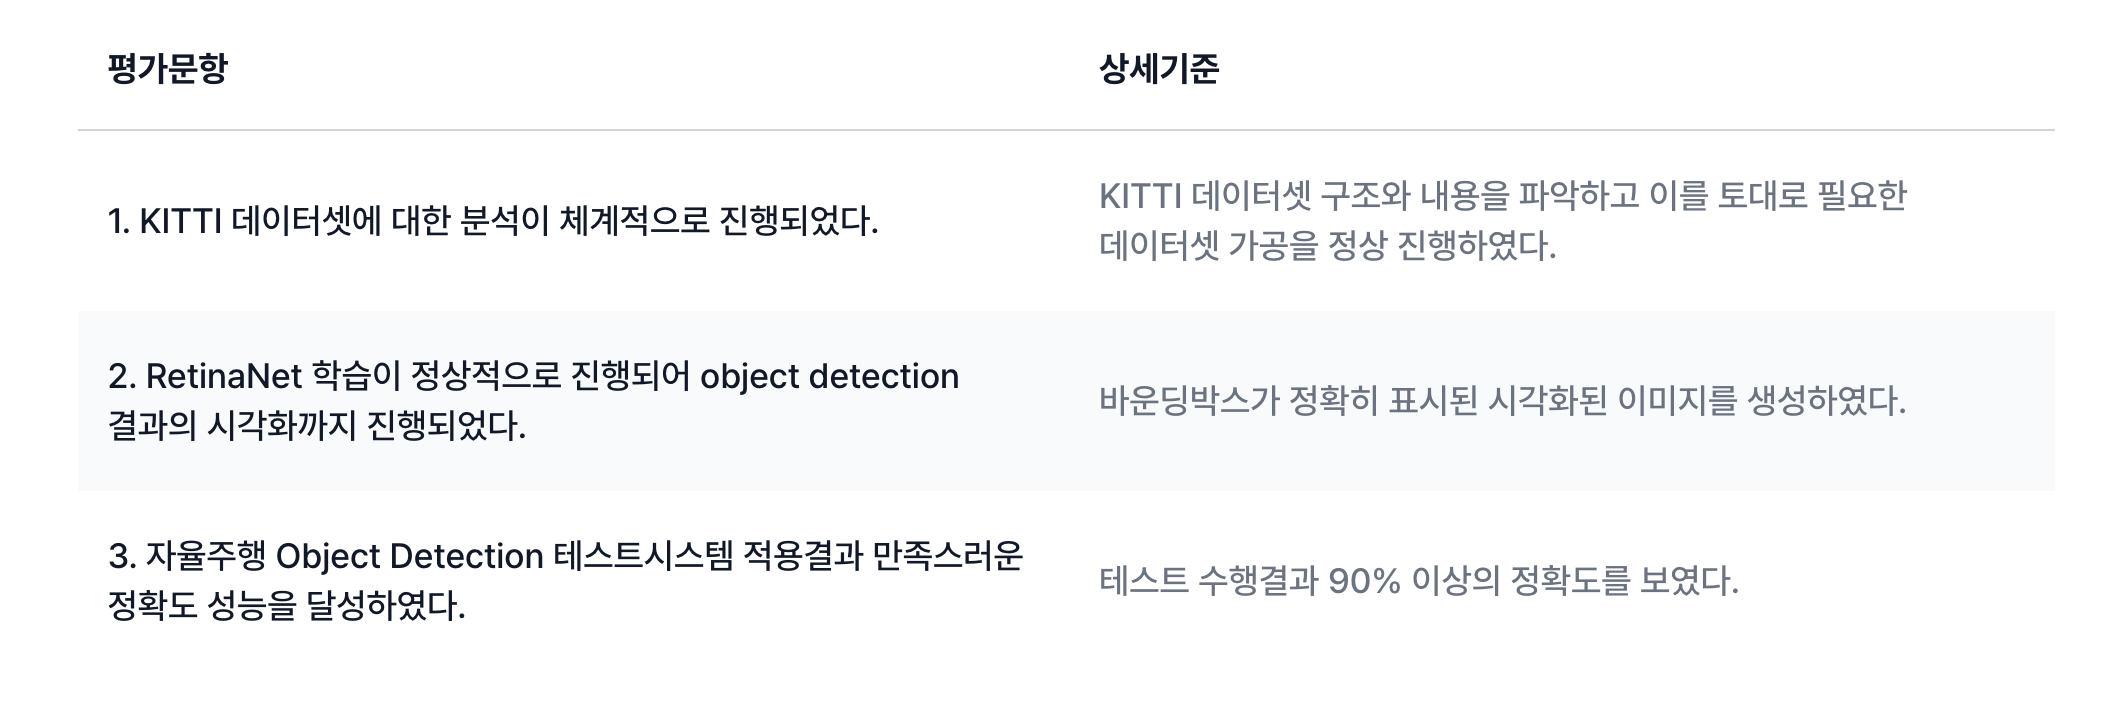

# 라이브러리 호출

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.set_visible_devices([gpus[0]], 'GPU')

## 데이터셋 

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
) # 저장된 데이터셋을 가져옴, 처음 시도시 매우 오래걸림

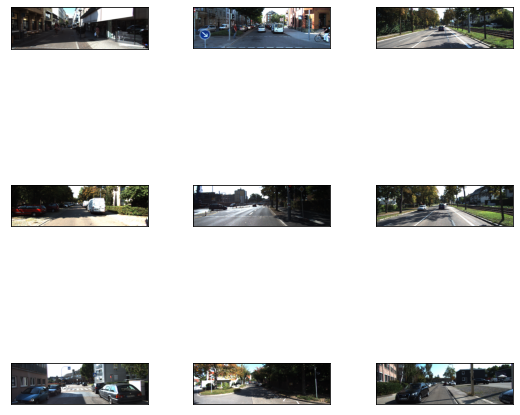

In [5]:
_ = tfds.show_examples(ds_train, ds_info)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-1.41, -1.72, -1.31, -1.63, -1.36, -1.52], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.33922666, 0.48384058, 0.53728   , 0.5649517 ],
       [0.2424    , 0.6840902 , 0.53885335, 0.8024477 ],
       [0.38301334, 0.5137762 , 0.52944   , 0.5871981 ],
       [0.42936   , 0.6642673 , 0.5223467 , 0.7001369 ],
       [0.38853332, 0.5061755 , 0.546     , 0.5238325 ],
       [0.46493334, 0.58929145, 0.53250664, 0.6137681 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.47, 1.6 , 4.41],
       [1.63, 1.69, 3.88],
       [1.46, 1.68, 4.1 ],
       [1.49, 1.64, 4.17],
       [1.83, 0.6 , 0.39],
       [1.6 , 1.75, 3.89]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ 1.05,  1.51, 16.58],
       [ 5.23,  1.65, 12.63],
       [ 2.25,  1.58

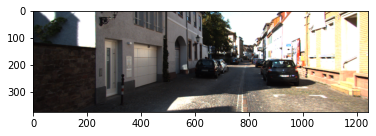

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show() # take 메소드를 사용하면 샘플 하나를 뽑아서 사용할 수 있음

# 1번달성
데이터셋 분석 및 가공

### 바운딩 박스

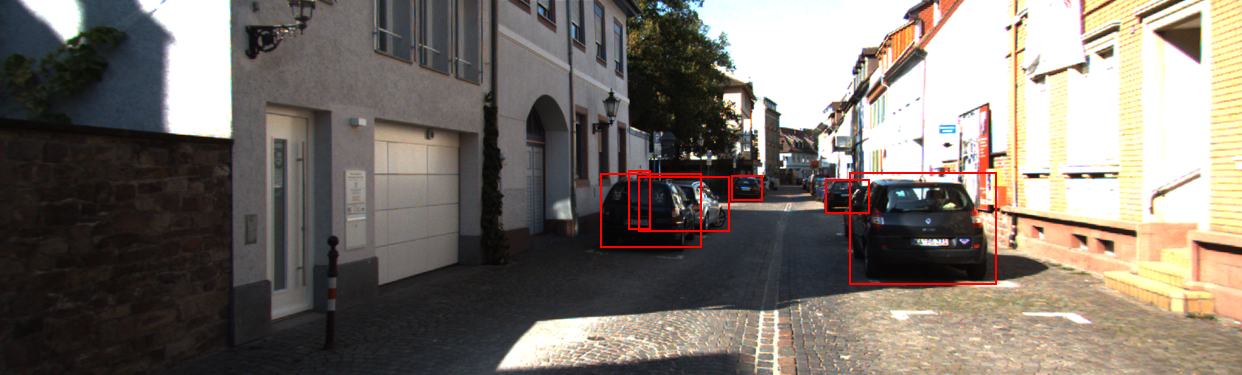

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

샘플로 뽑았던 이미지에서 바운딩 박스가 잘 그려진 것을 확인할 수 있다.

## 데이터 전처리

In [8]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

def preprocess_data(sample):# 선언한 함수들을 연결하는 함수
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [9]:
class AnchorBox:# 앵커박스
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [10]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [12]:
class LabelEncoder: #훈련 가능한 형태로 변환

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

# 모델정의

In [13]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [14]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [15]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [16]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [17]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

# 모델 학습
여기서는 가중치를 사용해서 진행함

In [18]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


In [19]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [20]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [21]:
# 이 코드를 사용하면 학습을 진행할수도있음

# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
# callbacks_list = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#         monitor="loss",
#         save_best_only=False,
#         save_weights_only=True,
#         verbose=1,
#     )
# ]

# epochs = 1

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

# 결과확인하기

In [22]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [23]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [24]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [25]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [26]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

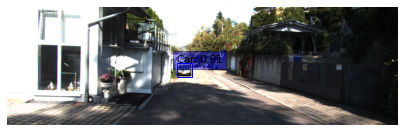

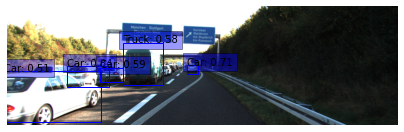

In [27]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)ㅇ
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 2번 달성
추론 시 모델의 바운딩 박스 결과 출력 완료

# Go? Stop?

In [68]:
def self_drive_assist(img_path, size_limit=300):
    # Step 1: 이미지 로드 및 전처리
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB 포맷으로 변환
    input_image, ratio = prepare_image(image_rgb)  # 전처리 및 크기 조정
    
    # Step 2: 객체 탐지 수행
    detections = inference_model.predict(input_image)
    
    # Step 3: 디텍션 결과 추출
    num_detections = int(detections.valid_detections[0])
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio  # 박스 크기 보정
    classes = detections.nmsed_classes[0][:num_detections]  # 클래스 ID
    scores = detections.nmsed_scores[0][:num_detections]  # 신뢰도 점수

    # Step 4: 클래스 ID를 문자열로 변환 (클래스 ID -> 이름)
    class_names = [int2str(int(class_id)) for class_id in classes]

    # Step 5: 사람(Pedestrian) 감지 확인
    pedestrian_detected = any(class_name == "Pedestrian" for class_name in class_names)

    # Step 6: 차량(Car) 감지 확인 및 크기 조건 만족 여부 체크
    car_detected = any(
        class_name == "Car" and ((box[2] - box[0]) >= size_limit or (box[3] - box[1]) >= size_limit)
        for class_name, box in zip(class_names, boxes)
    )
    
    # Step 7: 감지된 객체와 정지 조건 출력
    print(f"Detected objects:")
    for i, (class_name, box, score) in enumerate(zip(class_names, boxes, scores)):
        width, height = box[2] - box[0], box[3] - box[1]
        is_stop_condition = (class_name == "Pedestrian") or (class_name == "Car" and (width >= size_limit or height >= size_limit))
        print(f"  - Object {i + 1}: {class_name}, Score: {score:.2f}, Box: {box}, Width: {width:.2f}, Height: {height:.2f}, Stop Condition: {is_stop_condition}")
    
    # Step 8: 원본 이미지 시각화
    plt.figure(figsize=(10, 7))
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()
    plt.clf()  # 현재 figure를 초기화
    plt.close()  # 현재 figure를 닫음
    
    # Step 9: 추론한 이미지 시각화
    plt.figure(figsize=(10, 7))
    visualize_detections(image_rgb, boxes, class_names, scores)
    plt.title("Detection Result")
    plt.axis("off")
    plt.show()
    plt.clf()  # 현재 figure를 초기화
    plt.close()  # 현재 figure를 닫음

    # Step 10: 정지 조건 확인
    if pedestrian_detected or car_detected:
        return "Stop"
    else:
        return "Go"

Detected objects:
  - Object 1: Pedestrian, Score: 0.63, Box: [780.4891   60.63949 849.3004  215.28815], Width: 68.81, Height: 154.65, Stop Condition: True


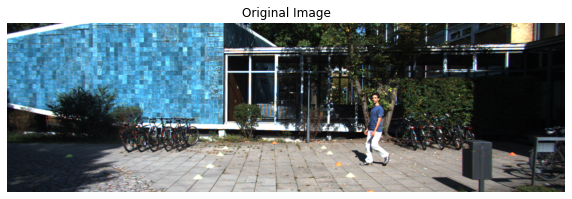

<Figure size 720x504 with 0 Axes>

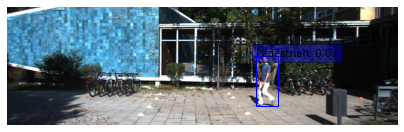

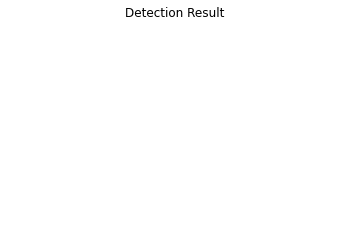

Stop


In [69]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

print(self_drive_assist(img_path))

Detected objects:
  - Object 1: Pedestrian, Score: 0.63, Box: [780.4891   60.63949 849.3004  215.28815], Width: 68.81, Height: 154.65, Stop Condition: True


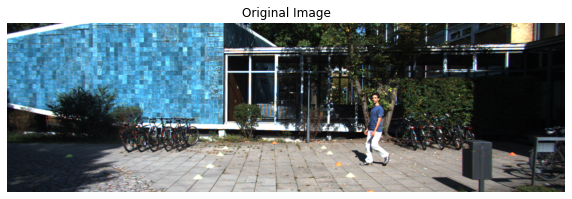

<Figure size 720x504 with 0 Axes>

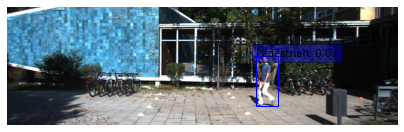

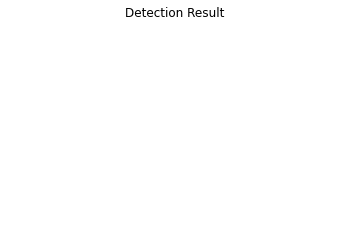

Detected objects:
  - Object 1: Pedestrian, Score: 0.57, Box: [423.5013    46.657364 496.3302   206.24571 ], Width: 72.83, Height: 159.59, Stop Condition: True


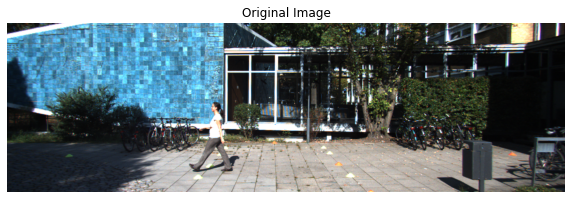

<Figure size 720x504 with 0 Axes>

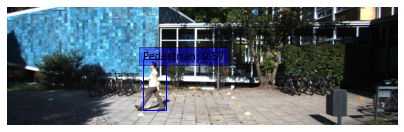

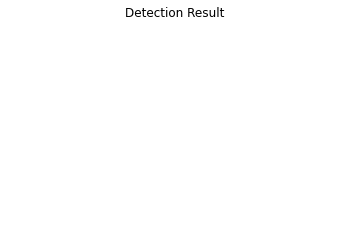

Detected objects:
  - Object 1: Car, Score: 0.90, Box: [ -6.632925   -0.6097618 306.63806   162.56013  ], Width: 313.27, Height: 163.17, Stop Condition: True
  - Object 2: Car, Score: 0.76, Box: [762.4521  161.98457 883.05566 202.10532], Width: 120.60, Height: 40.12, Stop Condition: False


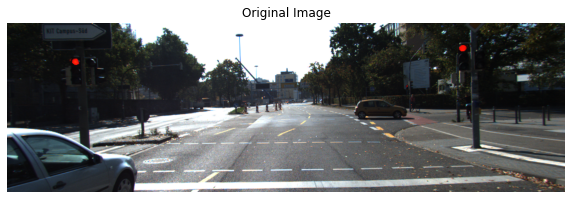

<Figure size 720x504 with 0 Axes>

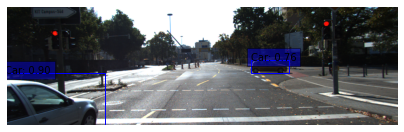

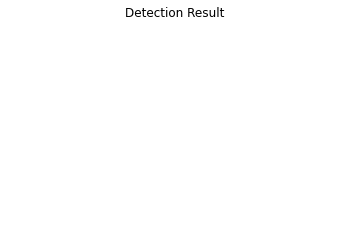

Detected objects:
  - Object 1: Car, Score: 0.80, Box: [361.67245 154.6089  494.76608 197.68105], Width: 133.09, Height: 43.07, Stop Condition: False
  - Object 2: Car, Score: 0.64, Box: [111.353745  80.748924 371.46915  205.93707 ], Width: 260.12, Height: 125.19, Stop Condition: False
  - Object 3: Car, Score: 0.57, Box: [701.8741  110.38571 813.1373  189.73157], Width: 111.26, Height: 79.35, Stop Condition: False
  - Object 4: Van, Score: 0.53, Box: [656.81305 155.57011 737.835   230.92172], Width: 81.02, Height: 75.35, Stop Condition: False
  - Object 5: Car, Score: 0.51, Box: [405.07104 161.31653 529.73596 204.1998 ], Width: 124.66, Height: 42.88, Stop Condition: False


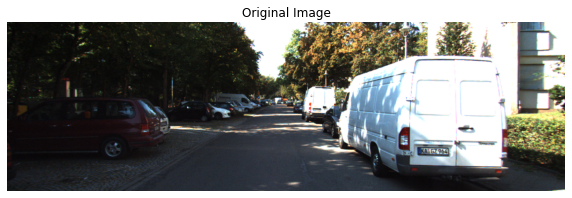

<Figure size 720x504 with 0 Axes>

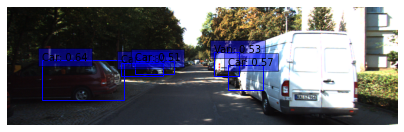

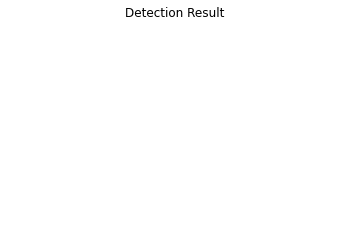

Detected objects:
  - Object 1: Car, Score: 0.95, Box: [566.15686 160.32376 619.01825 192.00706], Width: 52.86, Height: 31.68, Stop Condition: False
  - Object 2: Car, Score: 0.94, Box: [744.3864  132.28186 858.3431  203.33064], Width: 113.96, Height: 71.05, Stop Condition: False
  - Object 3: Car, Score: 0.86, Box: [ 872.20886    2.93705 1247.7874   195.31833], Width: 375.58, Height: 192.38, Stop Condition: True


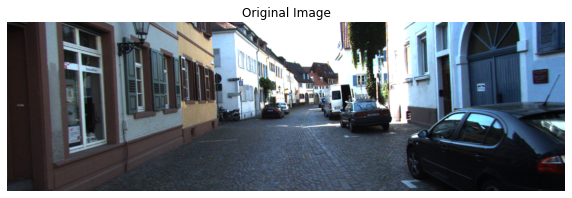

<Figure size 720x504 with 0 Axes>

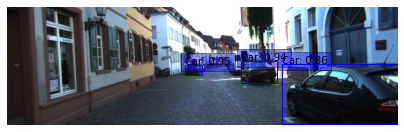

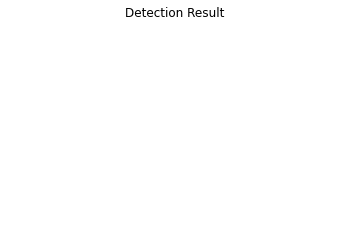

Detected objects:
  - Object 1: Car, Score: 0.92, Box: [592.4973  169.4263  626.708   198.10837], Width: 34.21, Height: 28.68, Stop Condition: False
  - Object 2: Car, Score: 0.65, Box: [375.57803 165.27217 417.32632 188.0812 ], Width: 41.75, Height: 22.81, Stop Condition: False
  - Object 3: Truck, Score: 0.63, Box: [197.0019  146.51572 364.6052  248.32855], Width: 167.60, Height: 101.81, Stop Condition: False


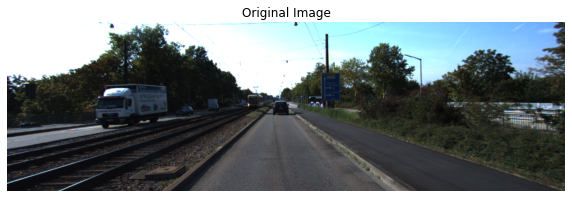

<Figure size 720x504 with 0 Axes>

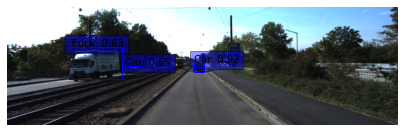

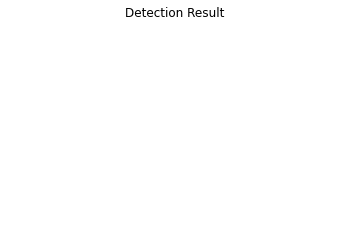

Detected objects:
  - Object 1: Car, Score: 0.95, Box: [514.9798  160.53906 572.86383 193.60892], Width: 57.88, Height: 33.07, Stop Condition: False
  - Object 2: Car, Score: 0.91, Box: [631.24475 159.94759 669.5334  199.81201], Width: 38.29, Height: 39.86, Stop Condition: False


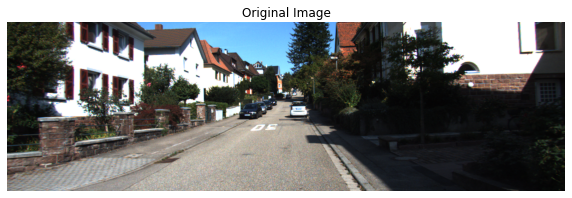

<Figure size 720x504 with 0 Axes>

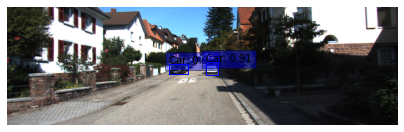

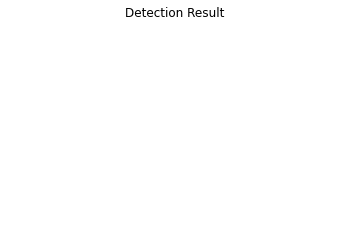

Detected objects:
  - Object 1: Car, Score: 0.73, Box: [542.22797 180.35832 570.072   200.30809], Width: 27.84, Height: 19.95, Stop Condition: False


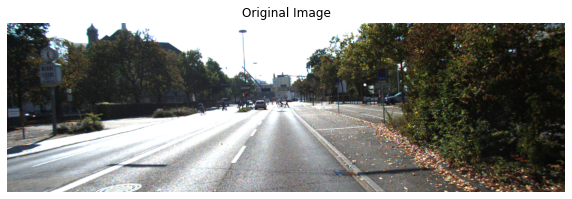

<Figure size 720x504 with 0 Axes>

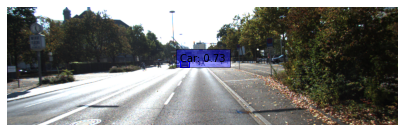

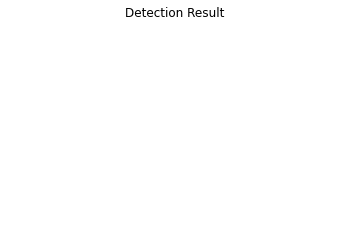

Detected objects:
  - Object 1: Car, Score: 0.75, Box: [694.2789  124.50323 794.2956  191.12003], Width: 100.02, Height: 66.62, Stop Condition: False


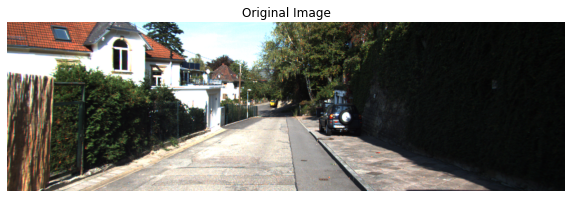

<Figure size 720x504 with 0 Axes>

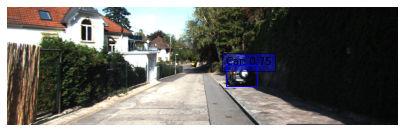

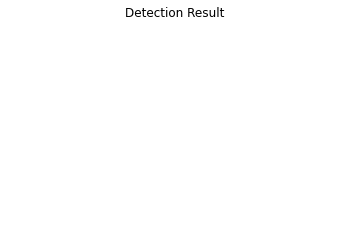

Detected objects:
  - Object 1: Car, Score: 0.72, Box: [449.0116  166.00806 494.14893 192.34299], Width: 45.14, Height: 26.33, Stop Condition: False
  - Object 2: Car, Score: 0.66, Box: [  9.349659  83.80748  230.4909   177.02124 ], Width: 221.14, Height: 93.21, Stop Condition: False
  - Object 3: Car, Score: 0.60, Box: [177.01465 125.25595 349.12552 190.41797], Width: 172.11, Height: 65.16, Stop Condition: False


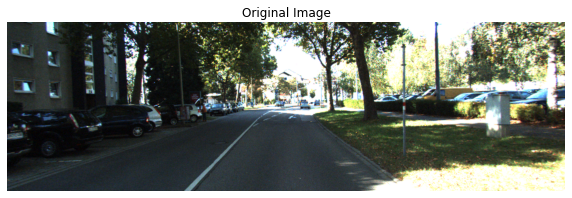

<Figure size 720x504 with 0 Axes>

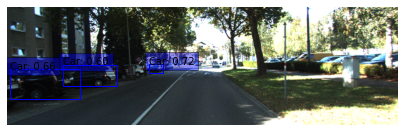

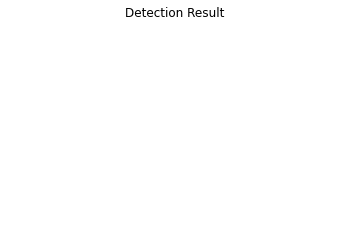

90점입니다.


In [70]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

# 3번
테스트 수행결과 90점(90퍼센트)이상의 정확도를 보였다. 완료

# 회고
중간에 휴가를 갔다와서 ocr부터 아무것도모르고 쭉쭉 하다보니 매우 빠르게 진행한 것 같다.

여기서 평가지표가 기존에 알고있던 정확도 이런게 아닌 신뢰도를 기반으로 하니 새로운 지식이 늘었다고 할 수 있다.